### Feature
'venue', 'innings', 'match_id', 'season', 'striker', 'bowler', 'balls',
       'runs_bat', 'extras', 'is_century', 'is_half_century', 'balls_played',
       'hard_hit_rate', 'fast_score_rate', 'run_bw_wickets', 'wiskets_3plus',
       'wickets_4plus', 'wickets_shortIndex', 'economy', 'strike_rate',
       'bowling_average', 'illegal_bowl_rate'

Data at row i has past ratings with season == "{current_season}" and match_id < {current_match}


In [147]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
from sklearn import preprocessing as skpp

In [2]:
def value_consistency(col, existing_values, unik_value, data):
    mask = data[col].isin(existing_values)
    #update
    data.loc[(mask), col] = unik_value


In [3]:
def clean_df(df_raw):
    # Venue
    value_consistency('venue',['M Chinnaswamy Stadium', 'M.Chinnaswamy Stadium'], 'M Chinnaswamy Stadium', df_raw)
    value_consistency('venue',['MA Chidambaram Stadium', 'MA Chidambaram Stadium, Chepauk',
                                 'MA Chidambaram Stadium, Chepauk, Chennai'], 'MA Chidambaram Stadium, Chepauk', df_raw)
    value_consistency('venue',['Punjab Cricket Association IS Bindra Stadium',
           'Punjab Cricket Association IS Bindra Stadium, Mohali',
           'Punjab Cricket Association Stadium, Mohali'], 'Punjab Cricket Association Stadium, Mohali', df_raw)
    value_consistency('venue',['Rajiv Gandhi International Stadium',
           'Rajiv Gandhi International Stadium, Uppal'], 'Rajiv Gandhi International Stadium, Uppal', df_raw)
    value_consistency('venue',['Wankhede Stadium', 'Wankhede Stadium, Mumbai'], 'Wankhede Stadium', df_raw)
    
    df_raw.season = df_raw.season.map(str)
    
    value_consistency('batting_team', ['Delhi Capitals', 'Delhi Daredevils'], 'Delhi Capitals', df_raw)
    value_consistency('batting_team', ['Pune Warriors','Rising Pune Supergiant', 'Rising Pune Supergiants'], 'Rising Pune Supergiant', df_raw)

    value_consistency('bowling_team', ['Delhi Capitals', 'Delhi Daredevils'], 'Delhi Capitals', df_raw)
    value_consistency('bowling_team', ['Pune Warriors','Rising Pune Supergiant', 'Rising Pune Supergiants'], 'Rising Pune Supergiant', df_raw)
    
    

In [4]:
# Batting metrics calculation
def count_4s(c):
    return ((c == 4) | (c==5)).sum()

def count_6s(c):
    return (c == 6).sum()

def get_balls_faced(c):
    return c.shape[0]

def get_wide_balls(c):
    return int(c.notnull().sum())

def get_total_runs(c):
    return c.sum()

def get_if_century(c):
    return int(c.sum() >= 100)

def get_if_half_century(c):
    return int(50 <= c.sum() < 100)

In [5]:
def bowler_wickets(s):
    return (s.notnull() & s.isin(['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket'])).sum()

def get_if_3knocked(s):
    w = bowler_wickets(s)
    return int(w == 3)
    
def get_if_4knocked(s):
    w = bowler_wickets(s)
    return int(3 < w)

def get_if_shortwickets(s):
    w = bowler_wickets(s)
    return int(w < 3)

In [6]:
def transformFile(filename):
    df = pd.read_csv('dataset/individual_match/'+filename)
    
    # Clean
    clean_df(df)
    
    batsman_stats = df.groupby(['match_id', 'season', 'venue', 'innings','striker']).agg(
        no_of_4s = ('runs_off_bat', count_4s),
        no_of_6s = ('runs_off_bat', count_6s),
        balls_faced = ('ball', get_balls_faced), # faced = played + wides
        total_wides = ('wides', get_wide_balls),
        total_runs = ('runs_off_bat', get_total_runs),
        is_century = ('runs_off_bat', get_if_century),
        is_half_century = ('runs_off_bat', get_if_half_century)
    ).reset_index()
    batsman_stats['balls_faced'] = batsman_stats['balls_faced'].astype('int')
    batsman_stats['total_wides'] = batsman_stats['total_wides'].astype('int')
        
    batsman_stats['balls_played'] = batsman_stats.balls_faced - batsman_stats.total_wides
#     batsman_stats['hard_hit_rate'] = (batsman_stats.no_of_4s + batsman_stats.no_of_6s) / batsman_stats.balls_played
#     batsman_stats['fast_score_rate'] = (batsman_stats.total_runs / batsman_stats.balls_played)
#     batsman_stats['run_bw_wickets'] = (batsman_stats.total_runs - (batsman_stats.no_of_4s*4 + batsman_stats.no_of_6s*6)) / (batsman_stats.balls_played - (batsman_stats.no_of_4s + batsman_stats.no_of_6s))
    
#     batsman_stats_to_keep = ['match_id', 'season', 'venue', 'innings', 'striker','is_century','is_half_century','run_bw_wickets', 'hard_hit_rate','fast_score_rate', 'balls_played']
#     batsman_stats_to_keep = ['match_id', 'season', 'venue', 'innings', 'striker','is_century','is_half_century','run_bw_wickets', 'hard_hit_rate','fast_score_rate', 'balls_played']
#     batsman_stats = batsman_stats.loc[:, batsman_stats_to_keep]
#     print('batsman_stats',filename,batsman_stats.shape)
    
    # Bowler
    bowler_stats = df.groupby(['match_id', 'season', 'venue', 'innings','bowler']).agg(
        runs_scored_bat = ('runs_off_bat', 'sum'),
        runs_scored_extra = ('extras', 'sum'),
        total_wides = ('wides', 'count'),
        total_noballs = ('noballs', 'count'),
        total_balls = ('ball', 'count'),
        wickets_taken = ('wicket_type', bowler_wickets),
        wiskets_3plus = ('wicket_type', get_if_3knocked),
        wickets_4plus = ('wicket_type', get_if_4knocked),
        wickets_shortIndex = ('wicket_type', get_if_shortwickets)
    ).reset_index()

#     bowler_stats['economy'] = (bowler_stats.runs_scored_bat + bowler_stats.runs_scored_extra) / (bowler_stats.total_balls // 6)
#     bowler_stats['strike_rate'] = bowler_stats.total_balls / bowler_stats.wickets_taken
#     bowler_stats['bowling_average'] = (bowler_stats.runs_scored_bat + bowler_stats.runs_scored_extra) / bowler_stats.wickets_taken
#     bowler_stats['illegal_bowl_rate'] = (bowler_stats.total_wides + bowler_stats.total_noballs) / bowler_stats.total_balls

#     bowler_stats_to_keep =  ['match_id', 'season', 'venue', 'innings', 'bowler','illegal_bowl_rate','wiskets_3plus','wickets_4plus','wickets_shortIndex','economy','strike_rate', 'bowling_average']
#     bowler_stats = bowler_stats.loc[:, bowler_stats_to_keep]
#     print('bowler_stats',filename,bowler_stats.shape)
    
    
    batsman_stats.to_csv('dataset/individual_match_m1/mod_batsman_stats_'+filename, index=False, na_rep="NaN")
    bowler_stats.to_csv('dataset/individual_match_m1/mod_bowler_stats_'+filename, index=False, na_rep="NaN")
    
    
    

## Actual Transformation

In [11]:
# assert False
import os
input_files = os.listdir('dataset/individual_match')
count = 0
for fileName in input_files:
    try:
        transformFile(fileName)
        f_reload = pd.read_csv('dataset/individual_match_m1/mod_batsman_stats_'+fileName, index_col=None, header=0)
        f_reload = pd.read_csv('dataset/individual_match_m1/mod_bowler_stats_'+fileName, index_col=None, header=0)
    except RuntimeError as e:
        print(e)
        count += 1
print("Total files failed ", count)

335995.csv
419111.csv
501251.csv
729313.csv
598000.csv
1082592.csv
392227.csv
1082644.csv
598015.csv
1136589.csv
598048.csv
336015.csv
501256.csv
1136600.csv
1136577.csv
501214.csv
1216522.csv
1216529.csv
501204.csv
548343.csv
980985.csv
501198.csv
336032.csv
392200.csv
1082647.csv
501237.csv
501229.csv
729281.csv
829727.csv
392226.csv
336031.csv
598023.csv
980919.csv
1216507.csv
419109.csv
548346.csv
336022.csv
1082621.csv
1216513.csv
1082638.csv
392236.csv
1216497.csv
829705.csv
501265.csv
1082601.csv
392192.csv
733999.csv
829781.csv
980989.csv
1216508.csv
981011.csv
392210.csv
392203.csv
336012.csv
548349.csv
548314.csv
419143.csv
419164.csv
392191.csv
419130.csv
336010.csv
729315.csv
548370.csv
598024.csv
598017.csv
336033.csv
734015.csv
419121.csv
1178423.csv
1082646.csv
598065.csv
734023.csv
829779.csv
419119.csv
548350.csv
392217.csv
1216539.csv
501261.csv
1136561.csv
501267.csv
501206.csv
501264.csv
1178407.csv
1178429.csv
392196.csv
1082635.csv
1136575.csv
1175364.csv
1136617.

1216523.csv
829717.csv
981009.csv
548367.csv
598061.csv
419145.csv
734041.csv
392189.csv
501219.csv
980967.csv
501211.csv
501205.csv
734035.csv
392208.csv
598066.csv
598032.csv
829769.csv
548375.csv
1136574.csv
392188.csv
336035.csv
419138.csv
980991.csv
392238.csv
829787.csv
829773.csv
729291.csv
829735.csv
980979.csv
336014.csv
392234.csv
419156.csv
729301.csv
1175363.csv
1082625.csv
335990.csv
980983.csv
336017.csv
598034.csv
1136580.csv
980973.csv
980909.csv
1136582.csv
1216506.csv
1237178.csv
980961.csv
548325.csv
419135.csv
392225.csv
981017.csv
419131.csv
980957.csv
501216.csv
548356.csv
980923.csv
1178422.csv
733985.csv
980917.csv
336013.csv
419148.csv
829795.csv
419110.csv
980915.csv
392213.csv
829739.csv
598053.csv
501268.csv
501253.csv
734021.csv
336036.csv
1082616.csv
598044.csv
597999.csv
829805.csv
1136611.csv
501246.csv
1178394.csv
419127.csv
1216498.csv
1136568.csv
980981.csv
1082629.csv
980921.csv
419165.csv
729279.csv
336025.csv
980971.csv
729307.csv
598003.csv
729303

### Merge all into One

In [12]:
# Merging all batsman
import os
mod_files = os.listdir('dataset/individual_match_m1')
li = []
for filename in mod_files:
    if('batsman' not in filename):
        continue
    df = pd.read_csv('dataset/individual_match_m1/'+filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
print(frame.shape)

(12269, 13)


In [13]:
frame.to_csv('dataset/all_matches_m1_batsman.csv', index=False, na_rep="NaN")

In [14]:
# Merging all bowlers
# assert False
import os
mod_files = os.listdir('dataset/individual_match_m1')
li = []
for filename in mod_files:
    if('bowler' not in filename):
        continue
    df = pd.read_csv('dataset/individual_match_m1/'+filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
print(frame.shape)

(9731, 14)


In [15]:
frame.to_csv('dataset/all_matches_m1_bowler.csv', index=False, na_rep="NaN")

## Final Data Population

In [21]:
b = batsman_stats.query('striker == "{0}" and season == "{1}" and match_id < {2}'
                        .format("V Kohli",'2009', 392218)).drop(
    ['striker','match_id','venue','season','innings'], axis=1).sum()

b['hard_hit_rate'] = (b.no_of_4s + b.no_of_6s) / b.balls_played
b['fast_score_rate'] = (b.total_runs / b.balls_played)
b['run_bw_wickets'] = (b.total_runs - (b.no_of_4s*4 + b.no_of_6s*6)) / (b.balls_played - (b.no_of_4s + b.no_of_6s))
b[5:]

no_of_4s            12
no_of_6s             2
balls_faced        132
total_wides          4
total_runs         138
is_century           0
is_half_century      1
balls_played       128
dtype: int64

In [42]:
bo = bowler_stats.query('bowler == "{0}" and season == "{1}" and match_id < {2}'
                        .format("SMSM Senanayake",'2013', 598043)).drop(
    ['match_id','season','venue', 'innings','bowler'], axis=1).sum()

bo['economy'] = (bo.runs_scored_bat + bo.runs_scored_extra) / (bo.total_balls // 6)
bo['strike_rate'] = bo.total_balls / bo.wickets_taken
bo['bowling_average'] = (bo.runs_scored_bat + bo.runs_scored_extra) / bo.wickets_taken
bo['illegal_bowl_rate'] = (bo.total_wides + bo.total_noballs) / bo.total_balls
bo[6:].to_frame()

,0
wiskets_3plus,0.000000
wickets_4plus,0.000000
wickets_shortIndex,5.000000
economy,7.250000
strike_rate,24.200000
bowling_average,29.000000
illegal_bowl_rate,0.008264


In [10]:
df = pd.read_csv('dataset/all_matches_clean.csv')
print('original all_matches_clean.csv',df.shape)
df.columns

striker_bowler = df.groupby(['venue', 'innings', 'match_id','season', 'striker', 'bowler']).agg(
    balls = ('ball', 'count'),
    runs_bat = ('runs_off_bat', 'sum'),
    extras = ('extras', 'sum'),
).reset_index().sort_values(by='match_id')
# striker_bowler[:1]
print('striker_bowler', striker_bowler.shape)
bowler_stats = pd.read_csv('dataset/all_matches_m1_bowler.csv')
batsman_stats = pd.read_csv('dataset/all_matches_m1_batsman.csv')

rdf = pd.DataFrame([], columns=['venue', 'innings', 'match_id', 'season', 'striker', 'bowler', 'balls',
       'runs_bat', 'extras', 'is_century', 'is_half_century', 'balls_played',
       'hard_hit_rate', 'fast_score_rate', 'run_bw_wickets', 'wiskets_3plus',
       'wickets_4plus', 'wickets_shortIndex', 'economy', 'strike_rate',
       'bowling_average', 'illegal_bowl_rate'])

for row in striker_bowler.iterrows():
    rf = row[1]
    print(row[0], end="")

    bt = batsman_stats.query('striker == "{0}" and season == "{1}" and match_id < {2}'
                            .format(rf.striker, rf.season, rf.match_id)).drop(
        ['striker','match_id','venue','season','innings'], axis=1)sum()
    
    bt['hard_hit_rate'] = (bt.no_of_4s + bt.no_of_6s) / bt.balls_played
    bt['fast_score_rate'] = (bt.total_runs / bt.balls_played)
    bt['run_bw_wickets'] = (bt.total_runs - (bt.no_of_4s*4 + bt.no_of_6s*6)) / (bt.balls_played - (bt.no_of_4s + bt.no_of_6s))
    bt
    rf = rf.append(bt[5:])
    
    bo = bowler_stats.query('bowler == "{0}" and season == "{1}" and match_id < {2}'
                            .format(rf.bowler, rf.season, rf.match_id)).drop(
        ['match_id','season','venue', 'innings','bowler'], axis=1).sum()

    bo['economy'] = (bo.runs_scored_bat + bo.runs_scored_extra) / (bo.total_balls // 6)
    if(bo.wickets_taken == 0):
        bo['strike_rate'] = 1000 #bo.total_balls / bo.wickets_taken
        bo['bowling_average'] = 1000#(bo.runs_scored_bat + bo.runs_scored_extra) / bo.wickets_taken
    else:
        bo['strike_rate'] = bo.total_balls / bo.wickets_taken
        bo['bowling_average'] = (bo.runs_scored_bat + bo.runs_scored_extra) / bo.wickets_taken
        
#     bo['strike_rate'] = bo.total_balls / bo.wickets_taken
#     bo['bowling_average'] = (bo.runs_scored_bat + bo.runs_scored_extra) / bo.wickets_taken
    bo['illegal_bowl_rate'] = (bo.total_wides + bo.total_noballs) / bo.total_balls
    
    rf = rf.append(bo[6:])
#   print(rf.index)
    rdf = rdf.append(rf, ignore_index=True)
#     print(type(rdf))
#     li.append(rdf)
#     print(rf)

# frame = pd.concat(li, axis=0, ignore_index=True)
print(rdf.shape)

original all_matches_clean.csv (194354, 23)
striker_bowler (40112, 9)
13976
15924


/home/rohit/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/home/rohit/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/rohit/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/home/rohit/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in long_scalars
/home/rohit/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


15925
15926
15927
15928
15929
15930
15931
13984
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
13977
13980
13981
13982
13983
15923
15922
15932
15920
15921
13973
13972
13971
13970
13969
13968
13967
13966
15916
15919
13974
13975
13979
13978
15918
15917
22695
22694
22693
22691
24099
24100
22696
22689
24097
24098
22690
22697
22703
22699
22707
22708
22709
22710
22711
22712
22713
22714
22715
22706
22705
22704
22702
22701
22700
22698
24101
22692
24118
24107
24117
24110
24111
24112
24103
24106
24108
24102
24109
24116
24104
24105
24115
24114
24113
8883
8906
8905
8904
8903
8902
8901
8900
8899
8882
8898
8896
8895
8894
8879
8880
8892
8891
8881
8889
8888
8887
8886
8885
8884
8897
8893
8890
10386
10392
10391
10390
10389
10388
10387
10380
10385
10384
10383
10382
10381
38294
38273
38296
38293
38272
38292
38290
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
38286
38287
38288
38291
38271
38289
36415
36413
36414
36416
36417
36418
36419
36412
36420
36422
36423
36

7135
7133
29754
29755
29756
29760
29758
29759
29761
29757
29763
30928
30933
30922
30923
30924
30925
30926
30927
29762
30929
30930
30934
30935
29772
29765
30938
30937
30936
29784
29783
29782
29781
29780
29779
29778
29764
29777
29775
29774
29773
30931
29771
29770
29769
29768
29767
29766
29776
30932
14058
16018
14074
14073
14072
14071
14070
14069
14068
16025
16024
16023
16022
14075
16021
16020
16019
16017
14057
14076
16015
14079
14078
14077
16016
16013
16012
14056
14067
14066
14064
14065
14062
14061
14060
16014
14059
14063
17864
19257
17865
17866
17867
19256
17863
19281
17861
17860
17859
17858
17878
17877
17876
17875
19254
17862
17857
19255
17869
19280
19279
19278
19277
19276
19275
19274
19273
17868
19271
19270
19269
19268
19267
19266
19272
19264
17871
17870
19265
17872
17873
19252
19253
17874
19258
19259
19260
19261
19262
19263
19282
27144
27140
27141
27142
27139
27143
27145
25495
27147
27148
27149
25496
25494
25493
27138
27146
27137
27129
27135
25505
25506
25507
25508
25509
25510
25502


22305
22294
22306
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22458
22471
22470
22474
22289
22290
22291
22292
22293
22473
22286
22285
22288
22284
22455
22456
22457
22479
22478
22477
22476
22475
22283
22287
22323
22321
22320
22319
22322
22317
22309
22484
22487
22486
22485
22318
22483
22482
22481
22307
22480
22310
22311
22312
22313
22314
22315
22316
22308
22339
22343
22340
22341
22342
22500
22350
22346
22347
22348
22349
22338
22345
22337
22499
22335
22334
22333
22332
22331
22330
22329
22328
22327
22326
22325
22324
22351
22336
22352
22344
22501
22502
22497
22496
22495
22494
22493
22498
22491
22490
22489
22488
22504
22503
22492
34651
34650
34649
34648
34647
34644
34645
34643
34642
34652
34646
34653
34661
34655
34656
34657
34658
34659
34660
34641
34662
34663
34482
34664
34665
34654
34505
34481
34494
34500
34499
34498
34497
34496
34495
34493
34501
34503
34502
34491
34490
34489
34488
34487
34486
34485
34484
34483
34492
34504
13177
13179
13178


/home/rohit/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in long_scalars


13581
13175
13174
13173
13180
13176
13181
13190
13183
13184
13185
13186
13187
13189
13172
13191
13192
13193
13194
13195
13196
13197
13182
13171
13188
13589
13582
13583
13590
13588
13587
13586
13585
13591
13584
22521
22519
22518
22517
22516
22515
22514
22513
22520
22362
22510
22360
22512
22531
22530
22529
22528
22527
22526
22525
22524
22361
22511
22522
22509
22379
22378
22377
22376
22375
22374
22373
22372
22371
22370
22369
22368
22367
22523
22366
22354
22355
22356
22357
22358
22359
22365
22364
22363
22505
22506
22507
22508
22353
13619
13602
13618
13620
13622
13617
13616
13615
13614
13613
13612
13611
13610
13609
13608
13607
13606
13605
13604
13603
13601
13621
13208
13198
13204
13203
13202
13201
13200
13199
13205
13597
13593
13594
13595
13600
13599
13598
13592
13206
13596
13209
13210
13211
13212
13213
13214
13215
13216
13207
13220
13219
13218
13217
22394
22582
22583
22396
22395
22555
22397
22584
22380
22385
22382
22383
22384
22386
22387
22388
22389
22390
22391
22392
22393
22381
22533
2255

1768
1869
1868
1867
1866
1865
1864
1870
1863
1861
1860
1859
1858
1857
1856
1862
1767
1887
1886
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1855
1854
1853
1773
1772
1774
1775
1776
1777
1778
1779
1780
1781
1771
1782
1784
1785
1786
1793
1792
1791
1790
1789
1788
1783
1770
1787
1814
1804
1902
1901
1900
1899
1898
1897
1896
1895
1894
1893
1892
1891
1890
1889
1803
1888
1802
1800
1904
1805
1903
1807
1808
1809
1810
1811
1812
1794
1795
1796
1797
1798
1799
1801
1813
1806
1823
1816
1817
1818
1819
1820
1821
1822
1815
1824
1825
1905
34784
34775
34786
34785
34783
34777
34781
34780
34779
34778
34787
34782
34788
34794
34790
34791
34792
34793
34795
34796
34797
34798
34774
34773
34772
34789
34776
34770
34610
34605
34606
34607
34608
34609
34771
34611
34612
34621
34614
34615
34616
34617
34618
34619
34620
34613
21945
21948
21947
21946
22116
21944
21942
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21943
22115
2

19359
19361
19362
19363
19364
19365
19366
19357
19352
19349
19350
17929
17928
17927
17926
19336
19337
19338
19339
19340
19341
19342
19343
19344
19345
19346
19347
19348
19351
17932
17930
17934
17948
17947
17946
17945
17944
17943
17942
17933
17949
17941
17940
17939
17938
17937
17936
17931
17935
28575
28893
28894
28895
28896
28897
28898
28899
28900
28892
28901
28903
28904
28905
28887
28582
28906
28907
28908
28560
28902
28891
28890
28889
28576
28577
28578
28579
28580
28581
28573
28572
28571
28570
28569
28888
28568
28567
28565
28564
28563
28562
28561
28574
28566
14134
16085
14136
14137
14138
14139
14140
14141
14142
14143
14135
14144
14146
14147
14148
14149
14150
14151
14152
16091
14145
16090
16084
16088
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16086
16072
16087
16089
5302
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
5323
5324
7250
7249
7248
7247
5312
5311
5310
5309
5308
5307
5306
5305
5304
5315
5316
5325
5317
5319
53

10634
10635
10636
10637
10638
10639
10640
10641
10643
10644
10645
10646
10648
10649
10650
10651
10652
10629
10655
10653
10654
10642
10647
9127
9119
9110
9111
9112
9113
9114
9115
9116
9117
9118
9135
9120
9121
9122
10657
9124
9125
9126
10656
9128
9129
9130
9131
9132
9123
9133
9134
36341
36342
36343
36346
36348
36347
36345
36344
36241
36253
36350
36349
36340
36351
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36254
36339
36267
36337
36257
36258
36259
36260
36261
36262
36263
36256
36265
36268
36269
36270
36271
36272
36273
36338
36266
36255
36264
36331
36327
36330
36332
36333
36334
36335
36336
36329
36328
19459
19468
19467
19466
19465
19464
19463
18047
19462
19444
19445
19446
19447
19448
19449
19450
19451
19461
19453
19454
19455
19456
19457
19458
19460
19452
18046
18055
19442
19441
19440
19439
18036
18037
18035
18038
18040
18041
18042
18043
18044
18045
18039
18034
19443
18032
18054
18053
18052
18051
18033
18049
18050
18028
18029
18030
18031
18048
31032
29883
31033
31034


21758
21641
10721
10722
10723
10724
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9208
9211
9207
9203
9205
10708
10709
10710
10711
10712
10713
10714
9206
10716
9194
9195
9196
10715
9198
9204
9210
9202
10720
10719
10718
10717
9197
9209
9199
9200
9201
2642
2636
2637
2638
2639
2640
2653
2652
2651
2650
2649
2648
2646
2645
2644
2643
2641
2647
2203
2213
2198
2199
2200
2201
2202
2204
2205
2206
2207
2209
2210
2211
2212
2214
2215
2216
2217
2218
2219
2220
2221
2197
2196
2208
2194
2195
7410
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7386
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7411
7399
7385
7383
5485
5484
5483
5482
5481
5480
5479
5478
5477
5476
5475
5474
5473
5472
5462
5471
5470
5469
5468
5467
5466
5465
5464
7381
7382
7384
5463
29946
29945
31093
31094
31095
31096
31097
31098
31099
31100
31101
31102
31103
31104
31105
31106
31107
31108
31109
31110
31111
31092
31090
31091
29958
29937
29938
29939
29940
29941
29942
29943
29944
31089
29948
29947
29950
29951
29952
29

16261
14331
16262
16263
16264
16266
16267
16268
16269
16270
14332
14338
14334
14335
14336
14337
14339
14340
14341
14342
14343
14344
16260
14333
14345
16265
16258
14346
14323
14324
14325
14326
14327
14328
14329
14330
16243
16244
16245
16246
16247
16248
16249
16250
16251
16252
16253
16254
16255
16256
16257
16259
14347
21840
21839
21719
21721
21722
21723
21724
21725
21825
21824
21823
21822
21720
21841
21843
21844
21845
21847
21848
21849
21726
21727
21728
21842
21729
21718
21716
21826
21827
21828
21829
21830
21831
21832
21833
21834
21717
21835
21837
21838
21709
21710
21711
21712
21713
21714
21715
21836
21730
21846
7478
7477
5575
5574
5573
5572
5571
5570
5593
5569
7476
5568
7489
7488
7487
7486
7485
7484
7483
7482
7481
7490
7475
7479
7473
5592
5591
5590
5589
5588
5587
5586
7474
7480
5584
5585
5582
5576
5577
5578
5583
5581
5580
5579
31171
31172
31173
31174
31175
31165
30070
31191
31166
31170
31167
31168
31178
31179
31180
31181
31182
31183
31184
31185
31186
31187
31188
31189
31169
31190
30071


12269
12268
12267
12257
12258
12052
12260
12276
12259
12278
12061
12060
12059
12266
12058
12265
12057
12277
12262
12056
12055
12054
12053
12264
12263
12261
19665
19666
19667
19668
19674
19664
19670
19671
19672
19669
19663
19659
19661
19660
19658
19657
19656
19676
19675
19677
19673
19662
19678
18257
18262
18263
18242
18243
18244
18245
18246
18247
18248
18249
18250
18251
18252
18255
18254
18256
18258
18259
18260
18253
18261
2382
2383
2384
2385
2386
2387
2388
2782
2783
2787
2785
2786
2381
2788
2790
2791
2792
2793
2794
2784
2380
2377
2378
2358
2359
2360
2361
2362
2363
2364
2365
2366
2379
2367
2369
2370
2371
2372
2373
2374
2375
2376
2795
2368
2796
2789
2779
2781
2780
36692
36690
36691
36688
36693
36694
36685
36686
36707
36706
36705
36704
36703
36702
36701
36687
36689
38547
38548
38549
36696
36697
36698
36708
36709
36700
38556
38557
38554
38553
38552
38551
36695
38550
38555
36699
12310
12309
12285
12074
12075
12076
12077
12078
12079
12080
12308
12307
12306
12305
12068
12069
12070
12071
12286

7595
7596
7586
7597
7598
7599
5701
7575
5698
7592
7585
7584
7583
7582
7593
7600
7580
7590
7589
7588
7587
7581
16408
16413
16412
16411
16438
16436
16435
14515
14526
14525
14513
14524
16410
16409
16437
14514
14521
14523
16420
16421
16422
16423
16424
16425
16426
16427
16428
16429
16430
16431
16432
16433
16434
16419
14527
16418
16416
14522
14520
14519
14518
14517
14516
14528
14529
14530
16414
16415
16417
38681
38680
38679
38678
38667
36828
38669
38668
36834
36833
36832
36831
36830
36817
36818
36819
36820
36821
36822
36823
36824
36825
36826
36827
36836
36837
36835
36839
38670
38671
38672
38673
38674
36838
38675
38676
38677
36829
36815
38666
36844
36843
36842
36841
36816
36840
36814
31314
31315
31316
31313
31318
31319
31320
31317
31312
30167
31310
30174
30175
30176
30177
30178
30179
30180
30173
30181
30183
30184
30185
30186
30187
30188
30189
30182
31311
30172
30170
31309
31308
31307
31306
31305
31304
31303
30171
31302
31300
31299
31298
31297
31296
30168
30169
31301
31321
14554
14532
16462
16

36903
36902
38730
38732
38733
38734
38735
38736
38737
38738
38745
38744
38743
38742
38741
36904
36905
36906
36907
36923
36922
36921
36920
36919
36918
36917
36925
36916
36914
36913
36912
36911
36910
36909
36908
36915
38740
38739
38748
38749
38750
38751
38752
38746
16508
16503
14601
14600
16510
14599
16507
16506
16505
14596
14597
14602
14595
14587
14588
14589
14590
14591
14592
14598
14603
14594
14605
16513
16491
16492
16493
16494
16495
16496
16497
16498
16499
16500
16501
16502
16512
16511
16509
16504
14593
14606
14604
10976
9513
10974
10990
10970
10969
10971
10989
9514
10987
10986
10985
10984
10983
10982
10977
10972
10973
10975
10978
10988
10980
9492
10979
9494
9495
9496
9497
9498
9499
9500
9491
9502
9503
9504
9501
9506
10981
9489
9512
9505
9511
9510
9490
9508
9507
9493
9509
35349
35353
35354
35355
35350
34958
35351
34957
34940
35352
34941
34955
34954
34953
34952
34951
34950
34949
34959
34942
34943
34944
34945
34946
34956
34960
34964
34962
35359
35358
35357
35356
34939
34938
34937
35360


25869
25868
25867
25866
25865
25864
25871
25863
25861
25860
25859
25858
25857
25856
25855
25862
27475
25872
25874
27477
27478
27479
27480
27481
27482
27483
25873
27484
27486
27487
27488
27490
25877
25876
25875
27485
25879
9575
11055
11045
11046
11047
9574
11049
11050
11051
11052
11053
11044
11054
11057
11058
11059
11060
11061
11062
11063
11064
11065
11056
11043
11048
9558
9576
9577
9578
9579
9580
9557
9572
9571
9570
9569
9573
9568
9567
9566
9565
9564
9563
9562
9561
9560
9559
18570
18571
18572
18573
18578
18575
18576
18577
19980
18574
18569
19981
18567
18565
18564
18563
18562
18561
18560
18559
18558
18557
19982
18568
19983
20006
19985
20008
20007
18556
20005
20004
20003
20002
20001
20000
19999
19998
19997
19996
19995
19994
19993
19992
19991
19990
19989
19988
19987
19986
19984
18555
18566
35049
35461
35462
35463
35464
35465
35466
35467
35468
35469
35470
35471
35472
35473
35035
35048
35047
35046
35034
35033
35032
35031
35030
35037
35460
35038
35040
35041
35042
35043
35044
35045
35039
3545

12148
12147
12146
12145
12144
12143
12142
12141
12370
12149
12361
12362
12135
12133
12134
12363
12136
12137
12138
12139
12140
12132
12131
12130
12364
12365
12366
12367
12368
7785
7788
7784
7786
7787
7793
7799
7798
7797
7796
7795
7783
7789
7790
7791
7792
7794
7782
7778
7780
5887
5888
7781
5890
5891
5892
5894
5895
5896
5897
5898
5899
5900
5901
5889
5903
5902
7779
7777
7776
5912
5911
5893
5909
5908
5907
5906
5905
5910
5904
18654
18653
18652
18650
18655
18649
18645
18646
18651
18656
18659
18658
18660
18661
18662
18664
18665
18666
18667
18668
18657
18663
20099
20088
20090
20091
20092
20093
20094
20095
20096
20097
20098
20115
20114
20089
20113
20111
20110
20109
20108
20107
20106
20105
20104
20103
20102
20101
20112
18647
18648
20100
5940
5938
5937
5936
5935
5934
5933
5932
5931
5930
5929
5928
5927
5926
5925
5924
5923
5922
5921
5919
5918
5917
5916
5915
5914
5941
5913
5939
5920
7805
7800
7801
7802
7803
7804
7806
7807
7808
7810
7809
7812
7813
7814
7815
7816
7817
7811
30411
31527
31526
30412
30409

13008
12855
12854
13009
12852
12851
12850
12849
12848
12847
12846
12845
12844
12856
12842
12840
12839
12838
12837
12836
12835
12834
12833
12832
12830
12829
12828
12841
12857
12853
12859
13007
13006
13005
12858
12831
12860
30493
30490
30508
31594
31595
31596
31597
31598
31599
31610
31611
30491
31612
31614
31600
31601
31602
31603
31604
31605
31606
31607
31608
31609
31613
30492
30496
30487
30507
30506
30505
30504
30494
30488
30489
30503
30502
30500
30499
30498
30497
30495
30501
9676
9678
9679
9680
9677
9675
9682
9672
9671
9685
9684
9683
9674
9681
11177
11189
9686
11169
11170
11171
11172
11173
11174
11175
11176
11190
11178
11180
11181
11182
11183
11184
11185
11186
11187
11188
11179
9687
9673
9694
9695
9692
9691
9690
9689
9688
9693
38997
39004
39003
39002
39001
39000
38999
37130
37143
37144
37145
37126
37127
37142
37129
37131
38991
38992
38993
38994
38995
38996
38998
38990
37128
37125
38979
38980
38981
38982
38983
38984
38985
38986
38987
38988
38989
37141
37140
37139
37138
37137
37136
37135

3568
4367
4372
4373
4374
3567
4375
4376
4377
4366
4378
3558
4380
4379
3569
3559
4370
4371
4364
4365
4382
4381
33899
33903
33900
33901
33902
33898
33904
33909
33906
33907
33908
33897
33210
33208
33905
33209
33194
33190
33186
33187
33188
33189
33191
33192
33193
33196
33197
33195
33199
33207
33206
33205
33198
33204
33202
33201
33200
33203
33218
33217
33213
33216
33215
33214
33239
33916
33241
33242
33212
33211
33219
33928
33240
33220
33237
33222
33233
33232
33231
33230
33236
33927
33221
33238
33228
33227
33226
33225
33224
33223
33229
33926
33234
33924
33937
33936
33935
33934
33933
33932
33931
33930
33925
33910
33911
33912
33929
33914
33915
33235
33917
33918
33919
33920
33921
33922
33913
33923
32341
32798
32797
32796
32793
32794
32776
32777
32792
32795
32342
32791
32779
32360
32359
32358
32357
32356
32355
32790
32778
32361
32789
32787
32786
32785
32782
32783
32337
32338
32339
32788
32340
32784
32345
32336
32333
32343
32344
32781
32346
32347
32780
32348
32349
32350
32351
32352
32353
32354
32

12932
12933
12934
12935
12940
13127
12936
13117
13116
13119
13120
13118
13122
13123
13124
13125
13126
13121
26119
26120
26121
26122
26123
26124
26125
26126
26132
26128
26129
26130
26131
26133
26134
26135
26118
26127
26117
27709
26115
27725
27726
27727
27728
27729
27720
27719
27718
27717
27716
27715
27714
27713
27712
27710
27708
26142
26141
26140
26139
26112
26113
26114
26116
26136
27711
26138
27724
27723
27722
26137
27721
29070
29069
29068
29067
29066
28754
28755
28756
28757
28758
28759
28760
28762
28763
28764
28765
28766
29071
29072
29094
28767
29076
29077
29078
29079
29080
29081
29082
29083
29073
29084
29086
29087
29088
29089
29090
29091
29092
29093
29085
28768
28761
28770
28769
29075
28774
28773
29074
28772
28771
9873
11335
11334
11311
11312
11313
11314
11317
11316
11318
11320
11321
11322
11323
11324
9859
11315
9860
9861
9851
9852
9853
9854
9855
9856
9872
9871
9870
9869
9868
9867
9866
9865
9864
9863
9862
11325
11326
11319
11328
11327
9858
11333
9857
11331
11329
11330
11332
27733
277

2876
3196
3195
3194
3193
3192
3191
3190
3189
3188
3187
2875
3185
3184
3186
2855
2877
2878
2879
3183
2880
2881
3182
37352
37353
37354
37355
37369
37363
37367
37366
37356
37357
37358
37359
37360
37361
37365
37364
37362
37368
39223
37370
39230
39229
39228
39227
39226
39225
39211
39212
39231
39213
39215
39216
39217
39218
39219
39220
39221
39222
39214
37351
39224
37371
37372
2894
3212
2905
2904
2903
2902
2901
2900
3213
3214
3232
3231
3230
2895
3229
2898
2897
2896
3217
3218
3219
3220
3221
3222
3228
3224
3225
3226
3227
2899
3223
3216
3203
2892
3210
3209
2890
3208
3207
2891
3204
3205
2889
2888
2887
2886
2885
2884
2883
3211
2882
3215
2893
3206
20689
20692
20693
20679
20675
20676
20677
20678
20691
20699
20698
20697
20680
20681
20682
20683
20684
20694
21213
20690
20696
20688
21201
21200
21199
21198
21204
20695
21205
21206
21207
21208
21209
21210
21211
21212
21197
21196
21195
21194
21193
21192
20685
20686
20687
21202
21203
28815
28814
28817
28818
28819
28820
28821
28822
28823
28824
28825
28826
288

1304
1305
1586
20331
20326
20330
20329
20328
20327
20325
18868
20323
20322
20321
20320
18867
20332
20324
20333
18878
20335
20334
18872
18873
18874
20341
18861
18862
18876
18863
18864
18865
18866
18871
18875
18877
18870
20336
20337
20338
20340
18884
20339
18882
18869
18881
18880
18879
18883
8145
8144
8143
8141
8140
8146
8139
8138
8137
8142
8147
6262
8149
8150
6260
6261
6263
6264
6265
6266
8136
6267
6268
8148
8135
8126
8133
6257
6256
6243
6244
6245
6246
6258
6247
6250
6251
6252
6253
6254
6255
6249
6259
8115
8116
8132
8131
8130
8129
8128
8127
8125
8124
8123
8122
8121
8120
8119
8118
8117
8134
6248
32002
32156
32009
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32157
32016
32158
32015
32013
32008
32007
32006
32005
32004
32003
32001
32000
31999
31998
31997
31996
31995
31994
31993
32011
32012
32014
32159
32010
32166
32162
32163
32169
32168
32167
32160
32164
32165
32161
37461
39318
39319
39320
39321
39324
39323
39325
39326
39327
39328
39330
39331
393

24976
24975
24970
24972
24971
24969
24968
24966
24965
24964
24963
24962
24980
24961
24973
24981
23631
24983
23659
23658
23657
23630
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23644
23645
23646
23647
23648
24984
24982
23643
24967
23653
23656
23652
23655
23654
23651
23650
23649
37599
39443
39444
39445
39446
39447
39449
39442
39450
39451
39452
39453
39454
39455
37603
37586
39448
39441
39439
37585
37602
37601
37600
37598
37597
37596
37595
37594
37593
37592
37591
37590
37589
37588
37587
39433
39434
39435
39436
39437
39438
39440
37584
37604
37580
37581
37582
37583
37577
37578
37579
29202
29204
29457
29458
29205
29207
29208
29209
29203
29201
29467
29459
29460
29461
29462
29463
29464
29465
29466
29468
29469
29470
29210
29211
29206
29213
29224
29225
29226
29227
29212
29223
29222
29221
29228
29214
29220
29219
29218
29215
29216
29217
20734
20735
20737
20733
20738
21244
21245
21246
21247
20736
20732
20726
20730
20729
20728
21248
21265
21266
21267
20723
20724
20725
20727
2073

26426
26425
26424
26423
26422
26421
26420
26419
26418
26417
27964
26427
26442
26428
26444
26443
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27966
27980
2982
2983
2984
2985
2986
2987
2988
2989
2981
2990
2992
2993
2994
2995
2996
2997
2998
2999
2991
3000
2980
2978
3318
3317
3316
3315
3314
3313
3312
3311
2979
3310
3308
2971
3307
2973
2974
2975
2976
2977
3309
2972
3320
3319
17123
17126
17125
17115
17116
17117
17118
17119
17120
17121
17122
15275
17124
15276
15277
15278
15279
15280
15281
15282
15283
15284
17127
17129
17128
17131
15268
15269
15270
15271
15272
15273
15274
17146
17145
17130
17143
17144
17141
17140
17139
17138
17137
17136
17135
17134
17133
17132
17142
6402
6405
6404
6403
6401
8266
6399
8267
8268
8269
8270
8271
8264
8263
8265
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6400
8262
6406
25071
23755
23754
23753
23752
23751
23750
23749
23748
23747
23745
23744
23743
23742
23741
23740
23739
23738
23737
23736
23756
25081
25080
25079
25060
2

8334
8335
8337
6489
8339
6497
6496
6495
6494
6493
6492
6491
6490
8329
6488
6487
6486
8342
8341
8340
8338
8328
6463
8326
6465
6466
6467
6468
6469
6470
6471
6472
6473
6464
6474
6475
8327
6476
6478
6479
6480
6481
6482
6483
6484
6485
8323
8324
8325
6477
15383
17264
15384
17265
17263
17281
17282
15406
17262
17261
17260
17259
15396
15397
15398
15399
15400
15401
15387
15386
15385
15402
15403
15404
17280
17279
15405
17277
15388
15389
15390
17272
17278
17271
17270
17269
17274
17268
17266
15391
15392
15393
15394
15395
17275
17276
17267
17273
29576
29354
29353
29352
29555
29350
29349
29575
29351
29562
29573
29558
29559
29560
29561
29348
29563
29564
29565
29566
29567
29568
29569
29570
29571
29572
29574
29347
29554
29345
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29346
29334
29553
29557
29336
29337
29338
29339
29340
29341
29342
29343
29344
29335
29556
8343
8349
8344
8371
8370
8369
8368
8367
8366
8365
8364
8363
8362
8372
8361
8359
8358
8357
8356
8355
8354
8353
8352
8351


20935
20952
20953
21486
20955
20937
11682
11681
11680
11679
11678
11677
11676
11675
11674
11673
11672
11671
11670
11669
11668
11667
11666
11665
11664
11663
11662
11661
11660
11659
11685
11684
11683
10273
10256
10252
10253
10254
10255
10257
10258
10259
10260
10262
10263
10261
10265
10266
10267
10268
10269
10270
10271
10272
10264
6628
6623
6622
6624
6625
6627
6629
8460
6631
6632
6633
6634
6635
6621
8459
6630
6620
6626
6618
8441
8442
8443
6619
8445
8446
8447
8448
8440
8449
8451
8452
8453
8454
8455
8456
8457
8458
8450
8439
8444
6614
6615
6617
6613
6612
6611
6610
6616
6609
6607
6608
10293
10292
10291
10294
10290
10289
10288
10296
11696
10298
11697
10287
10302
10303
11695
10301
10300
10299
10297
10286
11693
10284
11686
11687
11688
11689
11690
11691
11692
11698
11694
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10285
11699
10295
11701
11702
11703
11704
11705
11706
11707
11700
15483
15484
15485
15486
15489
15488
15482
15490
15491
15487
15481
15477
15479
15478
17335
15476
15475
1

26686
28206
26678
28204
28205
28195
28196
28197
28198
28194
28200
28201
28202
28203
28199
17437
15589
17436
17435
17434
15586
15587
17433
17432
15588
15590
15604
15592
15593
15594
17438
15603
15602
15601
15600
15599
15598
15597
15591
17439
15585
17430
15581
15582
15583
15584
17424
17423
15580
17422
17420
17419
17418
17417
17416
15596
17421
17431
15595
17429
17428
17427
17426
15575
15576
15577
17425
15578
15579
37868
37861
37862
37863
37864
37867
37865
37882
37881
37880
37879
37878
37877
37876
37866
37874
37873
37872
37871
37870
37869
37884
37875
37883
39739
37886
37887
37888
39753
39752
39751
37885
39750
39749
39748
39746
39745
39744
39743
39747
39741
39740
39738
39737
39736
39735
39734
39733
39742
8528
8527
8526
8525
8524
8516
8515
8520
8523
8522
8521
8513
8512
8529
8519
8514
8530
8532
8517
6703
6702
6701
6700
6699
6698
6697
6696
6695
6694
6693
6692
6691
6690
6689
6704
6705
6706
6707
8533
8534
8535
8536
8537
6718
6717
8531
6716
6714
6713
6712
6711
6710
6709
6708
6715
8518
15606
17440


26763
26764
26765
26766
26767
26768
26769
26770
26771
26775
26776
28293
28301
28306
28305
28304
28303
28302
28300
28299
28298
28296
28295
28297
28292
28291
28290
28289
28288
28287
28286
28285
28284
28294
37957
37954
37955
37956
37958
37966
37960
37961
37962
37963
37953
37959
37952
39814
37950
37949
37948
37947
37946
37945
37944
37943
39815
37964
39813
37951
37965
37969
39816
39840
39839
37967
39838
39837
39836
39835
39834
39833
39832
39831
39830
37968
39828
39829
39817
39819
39820
39821
39818
39823
39824
39825
39826
39827
39822
12773
12781
12774
12775
12776
12777
12778
12779
12780
12782
12770
12784
12785
12786
12787
12769
12768
12767
12766
12771
12783
12772
12571
12570
12567
12566
12565
12564
12563
12562
12561
12591
12590
12568
12588
12587
12586
12589
12584
12572
12573
12574
12575
12576
12577
12578
12585
12569
12579
12580
12581
12582
12583
26789
26791
26787
26786
26792
26793
26790
26788
28334
26784
26783
26782
26781
26794
26779
26778
26777
26785
26780
26795
26797
28318
28319
26796
2832

8752
8749
8754
6942
6943
6944
6945
6946
6947
6948
6949
8753
6951
6950
6953
6954
6955
6956
6957
6958
8755
6952
15773
15772
15771
15774
15770
15769
15755
15767
15766
15765
15764
15763
15775
15768
15776
17595
15778
17598
17597
17596
15762
17594
17593
17592
17591
15777
17590
17588
15783
15782
15781
15780
15779
17587
15754
17589
15761
17599
15759
15760
17605
17606
17583
17584
17585
17600
15757
15756
17586
17604
17603
17602
17582
15758
17601
28372
26853
28384
26837
26838
28373
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848
26849
26852
26851
26850
28383
28381
28382
28360
28365
28364
28363
28362
28361
28368
28359
28374
28375
28366
28376
28378
28379
28380
28369
28370
28371
28377
28367
23942
23941
23940
25247
25244
25245
25250
23939
25249
25246
25248
23938
23929
23936
23947
23948
23949
23950
23951
23952
25251
23953
23954
23930
23931
23932
23933
23934
23935
23937
25252
25255
25254
23946
23945
23944
23943
25262
25261
25260
25259
25258
25257
25256
25253
25263
573
215
216
217
218
574
71

30787
30786
30785
30784
31868
299
298
297
643
301
639
640
641
642
296
644
645
646
647
648
649
650
300
651
653
654
655
656
657
658
659
306
305
304
303
302
652
295
279
293
278
280
281
282
284
285
283
287
288
289
290
291
292
286
294
26963
26967
26966
26965
26964
28491
28496
28495
28494
28493
28492
26968
28497
26969
26977
26971
28498
28499
28500
28501
28502
28503
26970
26979
28490
26976
26975
26974
26973
26972
26978
28489
26962
26961
26952
26954
26955
26956
26953
26958
26959
26960
26957
17658
15850
15854
15853
17656
17657
17659
17664
17661
17662
17663
15849
17665
17666
17667
17660
15848
15844
15852
15831
15832
15833
15834
15835
15836
15837
15847
15838
15840
15841
15842
15843
17668
15845
15846
15839
17669
15851
17671
17672
17673
17674
17675
17676
17677
17678
17679
17670
31898
31897
31896
31895
31894
30824
30819
30822
30821
30820
31899
30817
30816
30823
31900
31904
31902
31916
31915
31914
31913
31912
31911
31901
31910
31908
31907
31906
31905
30815
31903
31909
30814
30818
30809
30807
30808
30

4479
4480
4481
4482
4470
4483
3655
4471
33351
33352
34033
34034
34035
34036
34037
34038
34039
34040
34041
34042
34043
34044
34045
34046
34047
34048
34049
34050
34051
34052
34053
34032
33350
34031
33374
33353
33354
33355
33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
34030
32860
32450
32862
32446
32447
32448
32449
32451
32452
32453
32454
32455
32456
32457
32458
32459
32460
32461
32462
32880
32881
32882
32883
32884
32445
32444
32443
32442
32864
32865
32866
32867
32868
32869
32870
32871
32872
32873
32885
32874
32876
32877
32878
32879
32436
32437
32438
32439
32440
32441
32861
32886
32875
32888
32889
32890
32891
32863
32887
34054
33399
33398
33397
33396
33395
33394
33393
33392
33390
34055
33389
33388
33387
33386
33385
33384
33383
33382
33381
33391
34056
34059
34058
33402
33401
33400
33375
33376
34076
34075
34074
34073
34072
34057
34071
34069
34067
34066
34065
34064
34063
34062
34061
34060
33380
34070
33379
34068
33377
33378
32483


33624
33625
33626
33627
33628
33629
34305
33631
33632
33633
33634
33635
33636
33637
33638
33639
34291
33640
34292
34294
34306
34307
34308
34309
34310
34311
34312
34313
34314
34315
34303
34302
34301
34300
34299
34298
34297
34296
34295
34293
33641
34304
4787
3998
3997
3996
4788
3995
3994
3993
3992
3991
3990
3989
3988
3987
3986
3985
3984
3983
3982
3981
3980
3979
3978
3977
3976
3975
3974
3973
4806
4805
3972
4803
4804
4797
4796
4795
4794
4793
4792
4791
4790
4789
3971
4778
4798
4780
4802
4801
4800
4799
4779
4785
4784
4786
4782
4781
4783
33025
32622
33026
33027
32617
32618
32619
32620
32621
33028
32623
32626
32625
33023
33022
33021
33020
33019
33018
33017
32610
32611
32612
32613
32614
32615
32624
33016
33014
33013
33012
33011
32635
32634
32633
32632
32631
32630
32629
32628
32627
33015
32616
33024
33660
34339
34340
34341
34342
34343
34344
34345
34346
34347
33654
34317
33662
33661
33659
33658
33657
33656
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
34338
34337
33655
3

In [11]:
rdf.to_csv('dataset/all_matches_m1_nn.csv', index=False, na_rep="NaN")

In [4]:
assert False

AssertionError: 

In [129]:
fe2 = pd.read_csv('./dataset/all_matches_m1_nn.csv')

In [130]:
fe2.columns

Index(['venue', 'innings', 'match_id', 'season', 'striker', 'bowler', 'balls',
       'runs_bat', 'extras', 'is_century', 'is_half_century', 'balls_played',
       'hard_hit_rate', 'fast_score_rate', 'run_bw_wickets', 'wiskets_3plus',
       'wickets_4plus', 'wickets_shortIndex', 'economy', 'strike_rate',
       'bowling_average', 'illegal_bowl_rate'],
      dtype='object')

In [131]:
fe2.sample(5)

,venue,innings,match_id,season,striker,bowler,balls,runs_bat,extras,is_century,...,hard_hit_rate,fast_score_rate,run_bw_wickets,wiskets_3plus,wickets_4plus,wickets_shortIndex,economy,strike_rate,bowling_average,illegal_bowl_rate
28314,Saurashtra Cricket Association Stadium,2,1082593,2017,CA Lynn,MS Gony,6,10,2,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1000.000000,1000.000000,NaN
19238,Subrata Roy Sahara Stadium,2,598067,2013,CM Gautam,AG Murtaza,4,4,0,0.0,...,0.181818,1.272727,0.666667,0.0,0.0,2.0,13.333333,1000.000000,1000.000000,0.027027
39564,Dubai International Cricket Stadium,1,1216543,2020/21,SS Iyer,JC Archer,4,1,1,0.0,...,0.131944,1.229167,0.720000,1.0,0.0,12.0,6.641509,18.705882,20.705882,0.025157
30078,Maharashtra Cricket Association Stadium,2,1082629,2017,BA Stokes,Ankit Soni,10,7,0,0.0,...,0.150538,1.365591,0.797468,0.0,0.0,2.0,6.285714,22.000000,22.000000,0.045455
37500,Sharjah Cricket Stadium,2,1216500,2020/21,YBK Jaiswal,K Rabada,4,2,0,0.0,...,0.166667,1.000000,0.400000,0.0,0.0,3.0,7.111111,9.000000,10.666667,0.055556


In [132]:
fe2['target'] = fe2['runs_bat'] + fe2['extras']

In [133]:
to_drop = ['match_id', 'season', 'striker', 'bowler', 'balls','runs_bat', 'extras','balls_played']
fe2 = fe2.drop(to_drop, axis=1)

In [134]:
fe2.shape

(40112, 15)

In [135]:
fe2['hard_hit_rate'] = fe2.hard_hit_rate.fillna(0)
fe2['fast_score_rate'] = fe2.hard_hit_rate.fillna(0)
fe2['run_bw_wickets'] = fe2.hard_hit_rate.fillna(0)

In [136]:
fe2.shape

(40112, 15)

In [137]:
fe2 = fe2.drop(fe2.query('economy == inf').index) #query('economy == inf').shape

In [138]:
fe2 = fe2.drop(fe2.query('strike_rate == 1000').index)

In [139]:
fe2 = fe2[~(fe2['economy'].isnull())]

In [140]:
fe2.shape

(31083, 15)

In [141]:
fe2.columns

Index(['venue', 'innings', 'is_century', 'is_half_century', 'hard_hit_rate',
       'fast_score_rate', 'run_bw_wickets', 'wiskets_3plus', 'wickets_4plus',
       'wickets_shortIndex', 'economy', 'strike_rate', 'bowling_average',
       'illegal_bowl_rate', 'target'],
      dtype='object')

In [142]:
fe2 = fe2[fe2['innings'] < 3]
inn = pd.get_dummies(fe2['innings'], drop_first=True, prefix='inn_')

In [143]:
fe2 = fe2.merge(inn, left_index=True, right_index = True)
print(fe2.shape)
fe2 = fe2.drop('innings',axis=1)
print(fe2.shape)

(31032, 16)
(31032, 15)


In [144]:
venue = pd.get_dummies(fe2['venue'], drop_first=True, prefix='v_')
fe2 = fe2.merge(venue, left_index=True, right_index = True)
print(fe2.shape)
fe2 = fe2.drop('venue',axis=1)
print(fe2.shape)

(31032, 49)
(31032, 48)


In [148]:
# fe2 = (fe2-fe2.min())/(fe2.max()-fe2.min())
x = fe2.values #returns a numpy array
min_max_scaler = skpp.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
fe2 = pd.DataFrame(x_scaled, columns=fe2.columns)
fe2.head(5)

,is_century,is_half_century,hard_hit_rate,fast_score_rate,run_bw_wickets,wiskets_3plus,wickets_4plus,wickets_shortIndex,economy,strike_rate,...,v__Saurashtra Cricket Association Stadium,v__Sawai Mansingh Stadium,v__Shaheed Veer Narayan Singh International Stadium,v__Sharjah Cricket Stadium,v__Sheikh Zayed Stadium,v__St George's Park,v__Subrata Roy Sahara Stadium,v__SuperSport Park,"v__Vidarbha Cricket Association Stadium, Jamtha",v__Wankhede Stadium
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.432432,0.130435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.621622,0.136646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.432432,0.130435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.432432,0.130435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.621622,0.136646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Data has shape  (31032, 48)
y_shape is  (31032,)
x_shape is  (31032, 47)

R2 score : LinearRegression = 0.02080031058545251
RMSE     : LinearRegression = 0.112863493264591

R2 score : BayesianRidge = 0.021528019146042743
RMSE     : BayesianRidge = 0.11282154727738407

R2 score : DecisionTreeRegressor = -0.8988414482435706
RMSE     : DecisionTreeRegressor = 0.1571673049387749

R2 score : RandomForestRegressor = -0.11700278424117583
RMSE     : RandomForestRegressor = 0.12054382898371381

R2 score : SVR = 0.007874697115507145
RMSE     : SVR = 0.11360596041107841
INFO:tensorflow:Assets written to: ./ipl_model_tf/assets

R2 score : Neural Network = -15395671641386.914
RMSE     : Neural Network = 0.11693632159714086


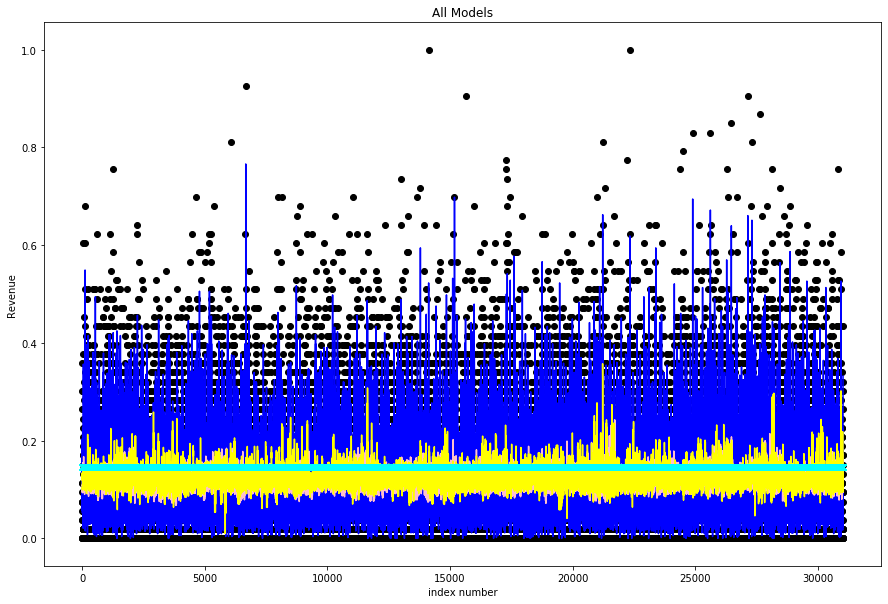

In [149]:
%run all_models.ipynb
do_traning(data=fe2)